<h1>E-commerce via Computer Vision</h1>

## Machine Learning: 3rd Level of Fine Tuning (4th Step)

# Step 1: Set environment variables, re-image serverless, ephmeral instance (if Datalab not already running), imports, unpickle prior data

In [1]:
# ENVIRONMENT VARIABLES
PROJECT = 'hidden-layers-llc'
REGION  = 'us-east1'
BUCKET  = 'hidden-layers-llc'
MODULE = 'ai'
COMPONENT = 'images-raw'
GS = 'gs://'

In [2]:
%%bash
gcloud config set project hidden-layers-llc
gcloud config set compute/region us-east1

Updated property [core/project].
Updated property [compute/region].


In [3]:
# ONLY UNCOMMENT AND RUN THIS SCRIPT IF THIS IS THE 1ST NOTEBOOK OPENED IN THIS SESSION
#!bash install_dl_libs.sh

In [4]:
# import necessary libraries
import time
import string
import os
import csv
from copy import deepcopy
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from numpy.random import seed
import pandas as pd
import pickle as pkl
import shutil 
from shutil import copy2
from orderedset import OrderedSet
from collections import OrderedDict
import warnings
from keras.engine import Model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils 
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16
from keras.models import model_from_json, load_model
from keras.applications.vgg16 import preprocess_input, decode_predictions
import glob
# Now we need TensorFlow itself, as well same control (see Section 3.2 below) of its memory allocation
import tensorflow as tf
from tensorflow import set_random_seed
from keras.backend import clear_session
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import scipy.misc
import pydot
from random import shuffle
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
warnings.filterwarnings('ignore') # Stop warning about pandas .ix slicing, which is deprecated but most effective

Using TensorFlow backend.


In [5]:
# GLOBAL VARIABLES - MODELING
# desired data field for each image
desired_fields = ['img_no', 'manufacturer', 'description', 'retailer_sku', 'manufacturer_sku', 'img_url', 'img_name']
curr_dir = os.getcwd() # set the current directory in which this notebook resides
#seed(1)  # set numpy seed for reproducibility
#set_random_seed(2) # set TensorFlow see, also needed for reproducibility

In [6]:
#retrieve summaries from target site scrape
copy2('../df_pages_CLEAN_pkl.pickle', '.')
copy2('../dir_paths.pickle', '.')
copy2('../brand_dictionary_pkl.pickle', '.')

'./brand_dictionary_pkl.pickle'

In [7]:
# Load the summary DataFrame to map searches on this site to correct labels
with open('df_pages_CLEAN_pkl.pickle', 'rb') as df_pp:
  df_pages = pkl.load(df_pp)

In [8]:
# Load the path details saved from target site scrape
with open('dir_paths.pickle', 'rb') as df_paths:
  home_dir = pkl.load(df_paths)
  project_folder = pkl.load(df_paths)
  target_site_folder = pkl.load(df_paths)
  images_folder = pkl.load(df_paths)
  images_train_folder = pkl.load(df_paths)
  images_validation_folder = pkl.load(df_paths)
  images_test_folder = pkl.load(df_paths)
  classes_list = pkl.load(df_paths)

In [9]:
# Load the brand_dict saved from target site scrape
with open('brand_dictionary_pkl.pickle', 'rb') as brand_dict_fid:
   brand_dict = pkl.load(brand_dict_fid)

In [10]:
# Load the labels_short dictionary, which tells us how many of which labels' images we need to create
with open('data_bal_penult.pickle', 'rb') as labels_short_dict:
  labels_short = pkl.load(labels_short_dict)
  img_counts = pkl.load(labels_short_dict)
  count_min = pkl.load(labels_short_dict)

In [11]:
# Load the mappings and meta-data persisted in the 1st ML Step (ML_model_1_final.ipynb)
with open('images_detail_pkl.pickle', 'rb') as image_details:
  dir_train_folders = pkl.load(image_details)
  dir_val_folders = pkl.load(image_details)
  df_ground_truth = pkl.load(image_details)
  img_all_idx_dict = pkl.load(image_details)
  img_train_idx_dict = pkl.load(image_details)
  img_val_idx_dict = pkl.load(image_details)
  n_classes = pkl.load(image_details)      #N.B.: This is used extensively below

In [12]:
# define some required constraints for VGG16 & image dataset paths
labels_list = sorted(classes_list) # Keras generates probabilities by class in alphabetical order
img_height_req, img_width_req, dim_color_channels = 224, 224, 3  # the last (3) is the RGB vector/pixel into VGG16
# paths to images dataset and its subsets
train_dir = './images/train'
validation_dir = './images/validation'
test_dir = './images/test'
top_model_weights_best = 'top_model_weights_Step4.h5'
train_class_cnt = 8 # of the 10 images sourced from other than target site/class 2 were randomly assigned to validation (val)
val_class_cnt = 2 # the 2 of the 10 images sourced from other than target site/class randomly assigned to validation (val)
train_cnt = 232 # 8 test images for each of the 29 classes/retailer_skus
val_cnt = 58 # 2 validation images for each of the 29 classes/retailer_skus
test_cnt = n_classes # 1 test image for each of the 29 classes/retailer_skus

# Step 2: Sequential Fine-Tuning

## Step 2.1: Helper Functions for Balance of this Notebook

In [13]:
# define a function to convert these BGR images to RGB
def preprocess_input_BGR(x):
    x = x[:,:,::-1]  # convert BGR images to RGB (height=OK,width=OK, but reverse order of 3 color channels, from BGR to RGB)
    return x

In [14]:
# define a function to process a .jpg (or .jpeg) file received from a user into a tensor for prediction
def process_img_in(img_in_path): # img_in_path is the full path to the .jpg uploaded by the user
  img_height_req, img_width_req = 224, 224
  img = cv2.imread(img_in_path)
  x = deepcopy(img)
  x = cv2.resize(x,(img_height_req, img_width_req)).astype('float32')
  x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR) # actually from BGR to RGB, but switch of 1st & 3rd color channels still works
  x = img_to_array(x)
  x = np.true_divide(x, 255) # scale np.array representation of img as required by VGG16
  x = np.expand_dims(x, axis=0) # TensorFlow expects 4th dim, for indices of images (i.e., a rank-4 tensor)

  return x

In [15]:
# define a function to return the fids of the top-5 matches in the test set to the input img
def get_top_5_matches(pred_labels_top5):
  global test_dir
  pred_fids = []
  pred_imgs = []
  for pred_label in pred_labels_top5:
    pred_fid = pred_label+'.jpg'
    pred_img = cv2.imread(os.path.join(test_dir,pred_label,pred_fid))
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR) # actually from BGR to RGB, but switch of 1st & 3rd color channels still works
    pred_fids.append(pred_fid)
    pred_imgs.append(pred_img)
  
  return pred_fids, pred_imgs

In [16]:
# define a helper function to translate the top n prediction indices to class labels (text) for ONE image
def get_top_n_labels_1_img(top_n_idx_img, idx_to_label_dict, n=5):
  if isinstance(top_n_idx_img, np.ndarray):
    top_n_idx_img_list = top_n_idx_img.tolist()
  else:
    top_n_idx_img_list = top_n_idx_img
  pred_labels_top_n = []  # the container/list for the top n predicted labels for 1 image
  pred_labels_top_n = [idx_to_label_dict[i] for i in top_n_idx_img_list]
  
  return pred_labels_top_n 

In [17]:
# define a function to translate the top n prediction indices to class labels (text) for ALL images
def get_top_n_labels_all(top_n_idxs_tout, idx_to_label_dict, n=5):
  pred_labels_top_n_all = [] # the list of list for predicted labels for all predictions
  for top_n_idx_row in top_n_idxs_tout:
    pred_labels_top_n = []  # the container/list for the top n predicted labels for 1 image
    pred_labels_top_n = get_n_pred_labels_1_img(top_n_idx_row, idx_to_label_dict)
    pred_labels_top_n_all.append(pred_labels_top_n)
  
  return pred_labels_top_n_all

In [18]:
# define a helper function to extract the indices of the top n predictions for ONE image
def get_top_n_idxs_1_img(probs_img, n=5):
  top_n_idxs = [] # the container for the indices for the top n matches for 1 image
  probs_copy = deepcopy(probs_img)
  if isinstance(probs_copy, np.ndarray):
    prob_list = probs_copy.tolist()
  else:
    prob_list = probs_copy
  probs_top_n = deepcopy(prob_list)
  probs_top_n = sorted(probs_top_n, reverse=True)[0:n]
  for prob_top_n in probs_top_n:
    prob_top_n_idx = prob_list.index(prob_top_n)
    top_n_idxs.append(prob_top_n_idx)
  
  return top_n_idxs

In [19]:
# define a function to extract the indices of the top n predictions for ALL predictions
def get_top_n_idxs_and_labels(prob_array, idx_to_label_dict, n=5):
  probs_all = deepcopy(prob_array)
  top_n_all_idxs = [] # list of lists, each row/sublist of which is the indices of the top n image preds for 1 image
  top_n_all_labels = [] # list of lists, each row/sublist of which is the labels of the top n image preds for 1 image
  for prob_vec_idx, prob_vec in enumerate(probs_all):
    top_n_idxs = [] # the container for those indices for the top n matches for 1 image
    top_n_labels = [] # the container for those labels for the top n matches for 1 image
    prob_vec_copy = deepcopy(probs_all[prob_vec_idx,:])
    top_n_idxs = get_top_n_idxs_1_img(prob_vec_copy, n)
    top_n_labels = get_top_n_labels_1_img(top_n_idxs, idx_to_label_dict, n)
    top_n_all_idxs.append(top_n_idxs)
    top_n_all_labels.append(top_n_labels)
  
  return top_n_all_idxs, top_n_all_labels

## Part 2.3 Load a Quality Integrated Model (bn & Classification) & Then Unfreeze More Layers

In [20]:
# Ensure that current session is set and that seeming problems with TF non-threaded avoided
clear_session()  # https://stackoverflow.com/questions/51032845/single-thread-impacts-model-accuracy-and-loss-with-tensorflow-keras-backend
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=24)
# Cause TF to allocate GPU memory dynamically, hopefully obviating out-of_memory ("OOM") & other problems
# From https://github.com/keras-team/keras/issues/4161
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
config.allow_soft_placement = True
device_count={'GPU': 8, 'CPU': 16} # Use GPU as default
sess = tf.Session(graph=tf.get_default_graph(), config=config)
set_session(sess)

In [21]:
model_step_prev = 'tf_serving_keras_wrenches_Step3.h5'
my_model = load_model(os.path.join('models',model_step_prev))
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                7453      
Total params: 21,144,925
Trainable params: 8,790,045
Non-trainable params: 12,354,880
_________________________________________________________________


In [22]:
# set all but final 2 layers of base/bn-extractor layers as untrainable; allow final to be trained
for layer_idx, layer in enumerate(my_model.get_layer('vgg16').layers):
  if layer_idx < 17:
    print('frozen layer: layer_idx: {} layer.name: {}'.format(layer_idx, layer.name))
    layer.trainable = False
  else:
    print('un-frozen layer: layer_idx: {} layer.name: {}'.format(layer_idx, layer.name))
    layer.trainable = True

frozen layer: layer_idx: 0 layer.name: input_1
frozen layer: layer_idx: 1 layer.name: block1_conv1
frozen layer: layer_idx: 2 layer.name: block1_conv2
frozen layer: layer_idx: 3 layer.name: block1_pool
frozen layer: layer_idx: 4 layer.name: block2_conv1
frozen layer: layer_idx: 5 layer.name: block2_conv2
frozen layer: layer_idx: 6 layer.name: block2_pool
frozen layer: layer_idx: 7 layer.name: block3_conv1
frozen layer: layer_idx: 8 layer.name: block3_conv2
frozen layer: layer_idx: 9 layer.name: block3_conv3
frozen layer: layer_idx: 10 layer.name: block3_pool
frozen layer: layer_idx: 11 layer.name: block4_conv1
frozen layer: layer_idx: 12 layer.name: block4_conv2
frozen layer: layer_idx: 13 layer.name: block4_conv3
frozen layer: layer_idx: 14 layer.name: block4_pool
frozen layer: layer_idx: 15 layer.name: block5_conv1
frozen layer: layer_idx: 16 layer.name: block5_conv2
un-frozen layer: layer_idx: 17 layer.name: block5_conv3
un-frozen layer: layer_idx: 18 layer.name: block5_pool


## Step 2.3 Data Generators

In [23]:
# create a TRAIN set ImageDataGenerator
batch_size = 4
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   zca_whitening=True,
                                   shear_range=0.45,
                                   zoom_range=0.45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function = preprocess_input_BGR)
  
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height_req, img_width_req),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 232 images belonging to 29 classes.


In [24]:
# create a VAL (VALIDATION) set ImageDataGenerator 
validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input_BGR)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(img_height_req, img_width_req),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 58 images belonging to 29 classes.


## Step 2.4 Integrated Model - 1st Level of Fine Tuning

In [25]:
# set model_top's hyperparamaters
learning_rate = 1.5e-3
epochs = 100 # increasing epsilon (below) slows training, suggesting that more epochs should be needed
beta_one = 0.9
beta_two = 0.999
epsilon = 1.5e-3 # increasing this deterrant to division by zero adds stability to the system/model
#decay_rate = learning_rate / epochs
amsgrad_bool = False
batch_size = 4

In [26]:
# ready the top _model for training
adam = Adam(lr=learning_rate, beta_1=beta_one, beta_2=beta_two, epsilon=epsilon, amsgrad=amsgrad_bool) #decay=decay_rate, 
my_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath=top_model_weights_best, verbose=1, save_best_only=True)
#execute training
history = my_model.fit_generator(train_generator,
                                 samples_per_epoch=train_cnt,
                                 epochs=epochs,
                                 validation_data=validation_generator,
                                 nb_val_samples=val_cnt,
                                 callbacks=[checkpointer], verbose=1)

Epoch 1/100
58/58 [==============================] - 12s 206ms/step - loss: 2.5337 - acc: 0.3405 - val_loss: 2.3932 - val_acc: 0.2876

Epoch 00001: val_loss improved from inf to 2.39320, saving model to top_model_weights_Step4.h5
Epoch 2/100
58/58 [==============================] - 9s 161ms/step - loss: 3.1094 - acc: 0.2241 - val_loss: 3.1719 - val_acc: 0.1786

Epoch 00002: val_loss did not improve from 2.39320
Epoch 3/100
58/58 [==============================] - 9s 160ms/step - loss: 3.2196 - acc: 0.1466 - val_loss: 2.5448 - val_acc: 0.2188

Epoch 00003: val_loss did not improve from 2.39320
Epoch 4/100
58/58 [==============================] - 9s 160ms/step - loss: 3.1814 - acc: 0.1422 - val_loss: 2.5040 - val_acc: 0.2321

Epoch 00004: val_loss did not improve from 2.39320
Epoch 5/100
58/58 [==============================] - 9s 160ms/step - loss: 2.6359 - acc: 0.2586 - val_loss: 2.1784 - val_acc: 0.3929

Epoch 00005: val_loss improved from 2.39320 to 2.17836, saving model to top_model

58/58 [==============================] - 9s 160ms/step - loss: 0.7661 - acc: 0.7198 - val_loss: 2.2071 - val_acc: 0.5179

Epoch 00087: val_loss did not improve from 1.30439
Epoch 88/100
58/58 [==============================] - 9s 160ms/step - loss: 0.8332 - acc: 0.6853 - val_loss: 2.3922 - val_acc: 0.5268

Epoch 00088: val_loss did not improve from 1.30439
Epoch 89/100
58/58 [==============================] - 9s 161ms/step - loss: 0.7746 - acc: 0.7241 - val_loss: 2.4037 - val_acc: 0.4821

Epoch 00089: val_loss did not improve from 1.30439
Epoch 90/100
58/58 [==============================] - 9s 160ms/step - loss: 0.8316 - acc: 0.7112 - val_loss: 2.3149 - val_acc: 0.5312

Epoch 00090: val_loss did not improve from 1.30439
Epoch 91/100
58/58 [==============================] - 9s 161ms/step - loss: 0.7871 - acc: 0.7112 - val_loss: 2.1563 - val_acc: 0.5133

Epoch 00091: val_loss did not improve from 1.30439
Epoch 92/100
58/58 [==============================] - 9s 160ms/step - loss: 0.8355 

In [27]:
(eval_loss, eval_accuracy) = my_model.evaluate_generator(train_generator,train_cnt)

The ultimate TRAINING Accuracy was 77.5862%
The ultimate EVALUATION Accuracy was 78.8793%
The ultimate TRAINING Loss was 0.6590624107501463
The ultimate EVALUATION Loss was 0.5821776128798031


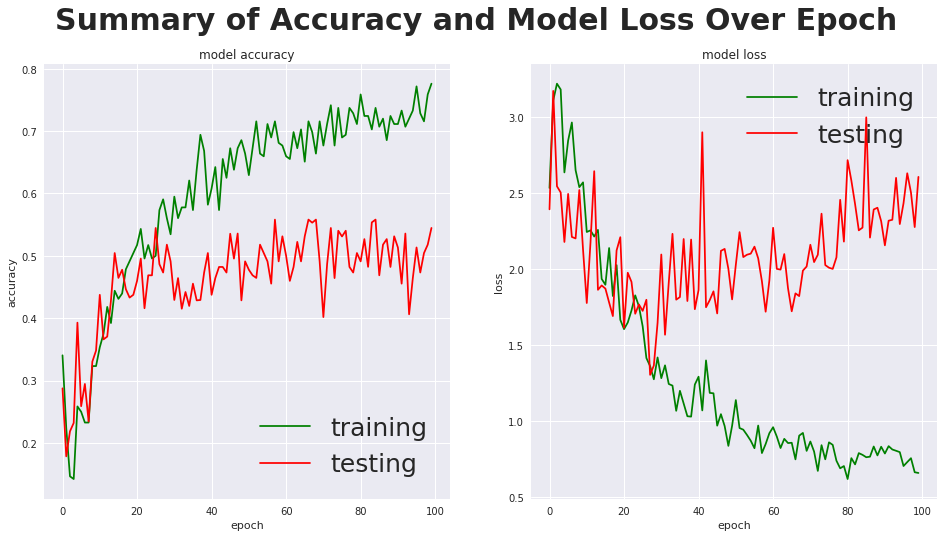

In [28]:
# Print most common usual results
train_accuracy = history.history['acc'][-1]
train_loss = history.history['loss'][-1]
print('The ultimate TRAINING Accuracy was {:.4f}%'.format(train_accuracy * 100))
print('The ultimate EVALUATION Accuracy was {:.4f}%'.format(eval_accuracy * 100))
print('The ultimate TRAINING Loss was {}'.format(train_loss))
print('The ultimate EVALUATION Loss was {}'.format(eval_loss))

# Graph the results
plt.clf()
graph_cnt = 2

# Total Graph size and Top Title
plt.figure(figsize=(16,8))
plt.suptitle('Summary of Accuracy and Model Loss Over Epoch', fontsize=30, weight='bold')
# Build Graph Contents
training_metrics = [history.history['acc'], history.history['loss']]
validation_metrics = [history.history['val_acc'], history.history['val_loss']]
horizontal_titles = ['model accuracy', 'model loss']
vertical_axis_labels = ['accuracy', 'loss']
# Build the graph contents
for i in range(graph_cnt):
    plt.subplot(121 + (i))
    plt.plot(training_metrics[i], color='green')
    plt.plot(validation_metrics[i], color='red')
    plt.title(horizontal_titles[i])
    plt.ylabel(vertical_axis_labels[i])
    plt.xlabel('epoch')
    plt.legend(['training', 'testing'], loc='best', prop={'size': 25})

plt.show()
plt.savefig('my_model_Step4.png')

In [29]:
# persist integrated model (architecture)
model_integrated_json = my_model.to_json()
with open("my_model_Step4.json", "w") as json_file:
    json_file.write(model_integrated_json)

In [30]:
# persist model_top (graph of weights)
my_model.save_weights("my_model_weights_Step4.h5")

In [31]:
# reload the same model_top architecture from this architecture
with open('my_model_Step4.json', 'r') as model_json:
  json_file = model_json.read()
my_model = model_from_json(json_file)

In [32]:
# load weights from best trial with some stochasticitty/volatility over a handful of trials (v4 better results)
my_model.load_weights(top_model_weights_best)    # THIS SHOULD BE CHANGED BACK TO "model_flatten_weights.h5"

In [33]:
model_name = "tf_serving_keras_wrenches_Step4.h5"
my_model.save(os.path.join('models',model_name))

In [34]:
# compile that model with the same parameters used to build it (above)
my_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Part 2.3.1 Let's show how the model performed, looking at the accuracy of predictions of the training set as validated by the validation set

In [35]:
# # First obtain the predictions & related data from the weighted graph generated with the VGG16 topped model
prediction_probs_val = my_model.predict_generator(validation_generator)
fids_ground_truth_val = validation_generator.filenames
label_to_idx_val_dict =  validation_generator.class_indices
idx_to_label_val_dict = dict((label, idx) for idx, label in label_to_idx_val_dict.items())

In [36]:
# Calculate the top-1 accuracy rate inputs
top_1_idxs_val_todos, top_1_labels_val_todos = get_top_n_idxs_and_labels(prediction_probs_val, idx_to_label_val_dict, 1)

In [37]:
# calculate the 1% accuracy rate in light of non-read files (both validation and train)
i = 0
error_count_1_val = 0

#fid_ground_truth_prior = fids_ground_truth_val[0].split('/')[0]
for fid_ground_truth_idx, label_truth in enumerate(fids_ground_truth_val):
  fid_truth_label, fid_truth_name = label_truth.split('/')[0], label_truth.split('/')[0][1]
  if (fid_ground_truth_idx != 0) and ((fid_ground_truth_idx % 2 == 0 and fid_truth_label == 
    fid_ground_truth_prior) or (fid_ground_truth_idx % 2 != 1 and fid_truth_label == fid_ground_truth_prior)):
    print('Skipping - fid_ground_truth_idx: {}, fid_ground_truth_prior: {}, &  fid_truth_label: {}'.format(fid_ground_truth_idx, fid_ground_truth_prior, fid_truth_label))
    fid_ground_truth_prior = fid_truth_label
    i += 1
    continue
  else:
    fid_ground_truth_prior = fid_truth_label
    if fid_truth_label != top_1_labels_val_todos[i][0]:
      print('ERROR: fid_truth_label: {} & top_1_labels_val_todos[i][0]: {}'.format(fid_truth_label, top_1_labels_val_todos[i][0]))
      error_count_1_val += 1
      i+= 1
    else:
      print('CORRECT: fid_truth_label: {} & top_1_labels_val_todos[i][0]: {}'.format(fid_truth_label, top_1_labels_val_todos[i][0]))
      i += 1

print("")
print("____________________________ FINAL RESULTS_____________________")
print('top-1 val errors: {} wrong out of {} predictions, or {:.4f}% accuracy'.format(error_count_1_val, i, (1 - (error_count_1_val)/i)*100))  

ERROR: fid_truth_label: IRW_BM2078606 & top_1_labels_val_todos[i][0]: IRW_BM2078612
ERROR: fid_truth_label: IRW_BM2078606 & top_1_labels_val_todos[i][0]: IRW_BM2078612
ERROR: fid_truth_label: IRW_BM2078608 & top_1_labels_val_todos[i][0]: IRW_BM2078606
CORRECT: fid_truth_label: IRW_BM2078608 & top_1_labels_val_todos[i][0]: IRW_BM2078608
ERROR: fid_truth_label: IRW_BM2078610 & top_1_labels_val_todos[i][0]: IRW_BM2078612
ERROR: fid_truth_label: IRW_BM2078610 & top_1_labels_val_todos[i][0]: IRW_BM2078612
CORRECT: fid_truth_label: IRW_BM2078612 & top_1_labels_val_todos[i][0]: IRW_BM2078612
CORRECT: fid_truth_label: IRW_BM2078612 & top_1_labels_val_todos[i][0]: IRW_BM2078612
CORRECT: fid_truth_label: IRW_BM2078700 & top_1_labels_val_todos[i][0]: IRW_BM2078700
CORRECT: fid_truth_label: IRW_BM2078700 & top_1_labels_val_todos[i][0]: IRW_BM2078700
CORRECT: fid_truth_label: IRW_BM2078706 & top_1_labels_val_todos[i][0]: IRW_BM2078706
CORRECT: fid_truth_label: IRW_BM2078706 & top_1_labels_val_todos

In [38]:
# calculate the top-5 accuracy rate inputs
top_5_idxs_val_todos, top_5_labels_val_todos = get_top_n_idxs_and_labels(prediction_probs_val, idx_to_label_val_dict, 5)

In [39]:
# calculate the 5% accuracy rate in light of non-read files (both validation and test)
i = 0
error_count_5_val = 0

#fid_ground_truth_prior = fids_ground_truth_val[0].split('/')[0]
for fid_ground_truth_idx, label_truth in enumerate(fids_ground_truth_val):
  fid_truth_label, fid_truth_name = label_truth.split('/')[0], label_truth.split('/')[0][1]
  if (fid_ground_truth_idx != 0) and ((fid_ground_truth_idx % 2 == 0 and fid_truth_label == 
    fid_ground_truth_prior) or (fid_ground_truth_idx % 2 != 1 and fid_truth_label == fid_ground_truth_prior)):
    print('Skipping - fid_ground_truth_idx: {}, fid_ground_truth_prior: {}, &  fid_truth_label: {}'.format(fid_ground_truth_idx, fid_ground_truth_prior, fid_truth_label))
    fid_ground_truth_prior = fid_truth_label
    i += 1
    continue
  else:
    fid_ground_truth_prior = fid_truth_label
    if fid_truth_label not in top_5_labels_val_todos[i]:
      print('ERROR: fid_truth_label: {} & top_5_labels_val_todos[i]: {}'.format(fid_truth_label, top_5_labels_val_todos[i]))
      error_count_5_val += 1
      i+= 1
    else:
      print('CORRECT: fid_truth_label: {} & top_5_labels_val_todos[i]: {}'.format(fid_truth_label, top_5_labels_val_todos[i]))
      i += 1

print("")
print("____________________________ FINAL RESULTS_____________________")
print('top-5 val errors: {} wrong out of {} predictions, or {:.4f}% accuracy'.format(error_count_5_val, i, (1 - (error_count_5_val)/i)*100))  

CORRECT: fid_truth_label: IRW_BM2078606 & top_5_labels_val_todos[i]: ['IRW_BM2078612', 'IRW_BM2078610', 'IRW_BM2078606', 'IRW_BM2078608', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078606 & top_5_labels_val_todos[i]: ['IRW_BM2078612', 'IRW_BM2078606', 'IRW_BM2078608', 'IRW_BM2078610', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078608 & top_5_labels_val_todos[i]: ['IRW_BM2078606', 'IRW_BM2078700', 'IRW_BM2078608', 'IRW_BM2078610', 'IRW_BM2078706']
CORRECT: fid_truth_label: IRW_BM2078608 & top_5_labels_val_todos[i]: ['IRW_BM2078608', 'IRW_BM2078612', 'IRW_BM2078610', 'IRW_BM2078606', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078610 & top_5_labels_val_todos[i]: ['IRW_BM2078612', 'IRW_BM2078610', 'IRW_BM2078608', 'IRW_BM2078606', 'IRW_BM2078700']
CORRECT: fid_truth_label: IRW_BM2078610 & top_5_labels_val_todos[i]: ['IRW_BM2078612', 'IRW_BM2078610', 'IRW_BM2078608', 'IRW_BM2078606', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078612 & top_5_labels_val_todos[i]: ['IRW_BM20786

### Part 2.3.2 Evaluate the New Fully-Connected Model on test Images

In [40]:
# reload the same integrated model architecture
with open('my_model_Step3.json', 'r') as model_json:
  json_file = model_json.read()
my_model = model_from_json(json_file)

In [41]:
# load weights from best trial with some stochasticitty/volatility over a handful of trials (v4 better results)
my_model.load_weights(top_model_weights_best)    # THIS SHOULD BE CHANGED BACK TO "model_flatten_weights.h5"

In [42]:
# compile that model with the same parameters used to build it (above)
my_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# create an ImageDataGenerator to read the test images in from images/test
batch_size = 29
test_features = np.zeros(shape=(test_cnt, 7, 7, 512))
test_labels = np.zeros(shape=(test_cnt,n_classes))

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                        #zca_whitening=True,
                                        #shear_range=0.2,
                                        #zoom_range=0.2,
                                        #horizontal_flip=True,
                                        preprocessing_function = preprocess_input_BGR)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height_req, img_width_req),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 29 images belonging to 29 classes.


In [44]:
#evaluate my_model against test set
(test_loss, test_accuracy) = my_model.evaluate_generator(generator=test_generator,
                              steps=batch_size,
                              verbose=1)

29/29 [==============================] - 10s 350ms/step


In [45]:
print('The ultimate TESTING Accuracy was {:.4f}%'.format(test_accuracy * 100))
print('The ultimate TESTING Loss was {}'.format(test_loss))

The ultimate TESTING Accuracy was 55.1724%
The ultimate TESTING Loss was 0.959296464920044


In [46]:
# # First obtain the predictions & related data from the weighted graph generated with the VGG16 topped model
prediction_probs_test = my_model.predict_generator(test_generator)
fids_ground_truth_test = test_generator.filenames
label_to_idx_test_dict =  test_generator.class_indices
idx_to_label_test_dict = dict((label, idx) for idx, label in label_to_idx_test_dict.items())

In [47]:
# Calculate the top-1 accuracy rate inputs
top_1_idxs_test_todos, top_1_labels_test_todos = get_top_n_idxs_and_labels(prediction_probs_test, idx_to_label_test_dict, 1)

In [48]:
# calculate the 1% accuracy rate in light of non-read files (test only)
i = 0
error_count_1_test = 0

for fid_ground_truth_idx, label_truth in enumerate(fids_ground_truth_test):
  fid_truth_label, fid_truth_name = label_truth.split('/')[0], label_truth.split('/')[0][1]
  if (fid_ground_truth_idx != 0) and ((fid_ground_truth_idx % 2 == 0 and fid_truth_label == 
    fid_ground_truth_prior) or (fid_ground_truth_idx % 2 != 1 and fid_truth_label == fid_ground_truth_prior)):
    print('Skipping - fid_ground_truth_idx: {}, fid_ground_truth_prior: {}, &  fid_truth_label: {}'.format(fid_ground_truth_idx, fid_ground_truth_prior, fid_truth_label))
    fid_ground_truth_prior = fid_truth_label
    i += 1
    continue
  else:
    fid_ground_truth_prior = fid_truth_label
    if fid_truth_label != top_1_labels_test_todos[i][0]:
      print('ERROR: fid_truth_label: {} & top_1_labels_test_todos[i][0]: {}'.format(fid_truth_label, top_1_labels_test_todos[i][0]))
      error_count_1_test += 1
      i+= 1
    else:
      print('CORRECT: fid_truth_label: {} & top_1_labels_test_todos[i][0]: {}'.format(fid_truth_label, top_1_labels_test_todos[i][0]))
      i += 1

print("")
print("____________________________ FINAL RESULTS_____________________")
print('top-1 test errors: {} wrong out of {} predictions, or {:.4f}% accuracy'.format(error_count_1_test, i, (1 - (error_count_1_test)/i)*100))  

ERROR: fid_truth_label: IRW_BM2078606 & top_1_labels_test_todos[i][0]: IRW_BM2078612
ERROR: fid_truth_label: IRW_BM2078608 & top_1_labels_test_todos[i][0]: IRW_BM2078612
ERROR: fid_truth_label: IRW_BM2078610 & top_1_labels_test_todos[i][0]: IRW_BM2078612
CORRECT: fid_truth_label: IRW_BM2078612 & top_1_labels_test_todos[i][0]: IRW_BM2078612
CORRECT: fid_truth_label: IRW_BM2078700 & top_1_labels_test_todos[i][0]: IRW_BM2078700
CORRECT: fid_truth_label: IRW_BM2078706 & top_1_labels_test_todos[i][0]: IRW_BM2078706
CORRECT: fid_truth_label: KTI_3239 & top_1_labels_test_todos[i][0]: KTI_3239
CORRECT: fid_truth_label: PTY_FA-113-8TAVSE & top_1_labels_test_todos[i][0]: PTY_FA-113-8TAVSE
CORRECT: fid_truth_label: PTY_J708L & top_1_labels_test_todos[i][0]: PTY_J708L
CORRECT: fid_truth_label: PTY_J708S & top_1_labels_test_todos[i][0]: PTY_J708S
ERROR: fid_truth_label: PTY_J712S & top_1_labels_test_todos[i][0]: PTY_J708S
ERROR: fid_truth_label: PTY_J715S & top_1_labels_test_todos[i][0]: PTY_J708S


In [49]:
# calculate the top-5 accuracy rate inputs
top_5_idxs_test_todos, top_5_labels_test_todos = get_top_n_idxs_and_labels(prediction_probs_test, idx_to_label_test_dict, 5)

In [50]:
# calculate the 5% accuracy rate in light of non-read files (test only)
i = 0
error_count_5_test = 0

for fid_ground_truth_idx, label_truth in enumerate(fids_ground_truth_test):
  fid_truth_label, fid_truth_name = label_truth.split('/')[0], label_truth.split('/')[0][1]
  if (fid_ground_truth_idx != 0) and ((fid_ground_truth_idx % 2 == 0 and fid_truth_label == 
    fid_ground_truth_prior) or (fid_ground_truth_idx % 2 != 1 and fid_truth_label == fid_ground_truth_prior)):
    print('Skipping - fid_ground_truth_idx: {}, fid_ground_truth_prior: {}, &  fid_truth_label: {}'.format(fid_ground_truth_idx, fid_ground_truth_prior, fid_truth_label))
    fid_ground_truth_prior = fid_truth_label
    i += 1
    continue
  else:
    fid_ground_truth_prior = fid_truth_label
    if fid_truth_label not in top_5_labels_test_todos[i]:
      print('ERROR: fid_truth_label: {} & top_5_labels_test_todos[i]: {}'.format(fid_truth_label, top_5_labels_test_todos[i]))
      error_count_5_test += 1
      i+= 1
    else:
      print('CORRECT: fid_truth_label: {} & top_5_labels_test_todos[i]: {}'.format(fid_truth_label, top_5_labels_test_todos[i]))
      i += 1

print("")
print("____________________________ FINAL RESULTS_____________________")
print('top-5 test errors: {} wrong out of {} predictions, or {:.4f}% accuracy'.format(error_count_5_test, i, (1 - (error_count_5_test)/i)*100)) 

CORRECT: fid_truth_label: IRW_BM2078606 & top_5_labels_test_todos[i]: ['IRW_BM2078612', 'IRW_BM2078608', 'IRW_BM2078606', 'IRW_BM2078610', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078608 & top_5_labels_test_todos[i]: ['IRW_BM2078612', 'IRW_BM2078608', 'IRW_BM2078606', 'IRW_BM2078610', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078610 & top_5_labels_test_todos[i]: ['IRW_BM2078612', 'IRW_BM2078608', 'IRW_BM2078606', 'IRW_BM2078610', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078612 & top_5_labels_test_todos[i]: ['IRW_BM2078612', 'IRW_BM2078608', 'IRW_BM2078606', 'IRW_BM2078610', 'SNY_90-948']
CORRECT: fid_truth_label: IRW_BM2078700 & top_5_labels_test_todos[i]: ['IRW_BM2078700', 'IRW_BM2078606', 'SNY_90-948', 'IRW_BM2078706', 'SNY_90-950']
CORRECT: fid_truth_label: IRW_BM2078706 & top_5_labels_test_todos[i]: ['IRW_BM2078706', 'SBD_J795G', 'IRW_BM2078700', 'SBD_J795S', 'SNY_90-948']
CORRECT: fid_truth_label: KTI_3239 & top_5_labels_test_todos[i]: ['KTI_3239', 'URR_708S', 'RT

### Part 2.4 Test img input and return of top-5 best predictions

In [51]:
# choose, get, and view the image
fids_in = [fid for fid in os.listdir('.') if fid.endswith('.jpg')]
fids_sample = fids_in[0:9] 
imgs_sample = []
for fid in fids_sample:
  img = cv2.imread(fid)
  img = cv2.cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # actually from BGR to RGB, but 1st & 3rd channel swap works 
  imgs_sample.append(img)

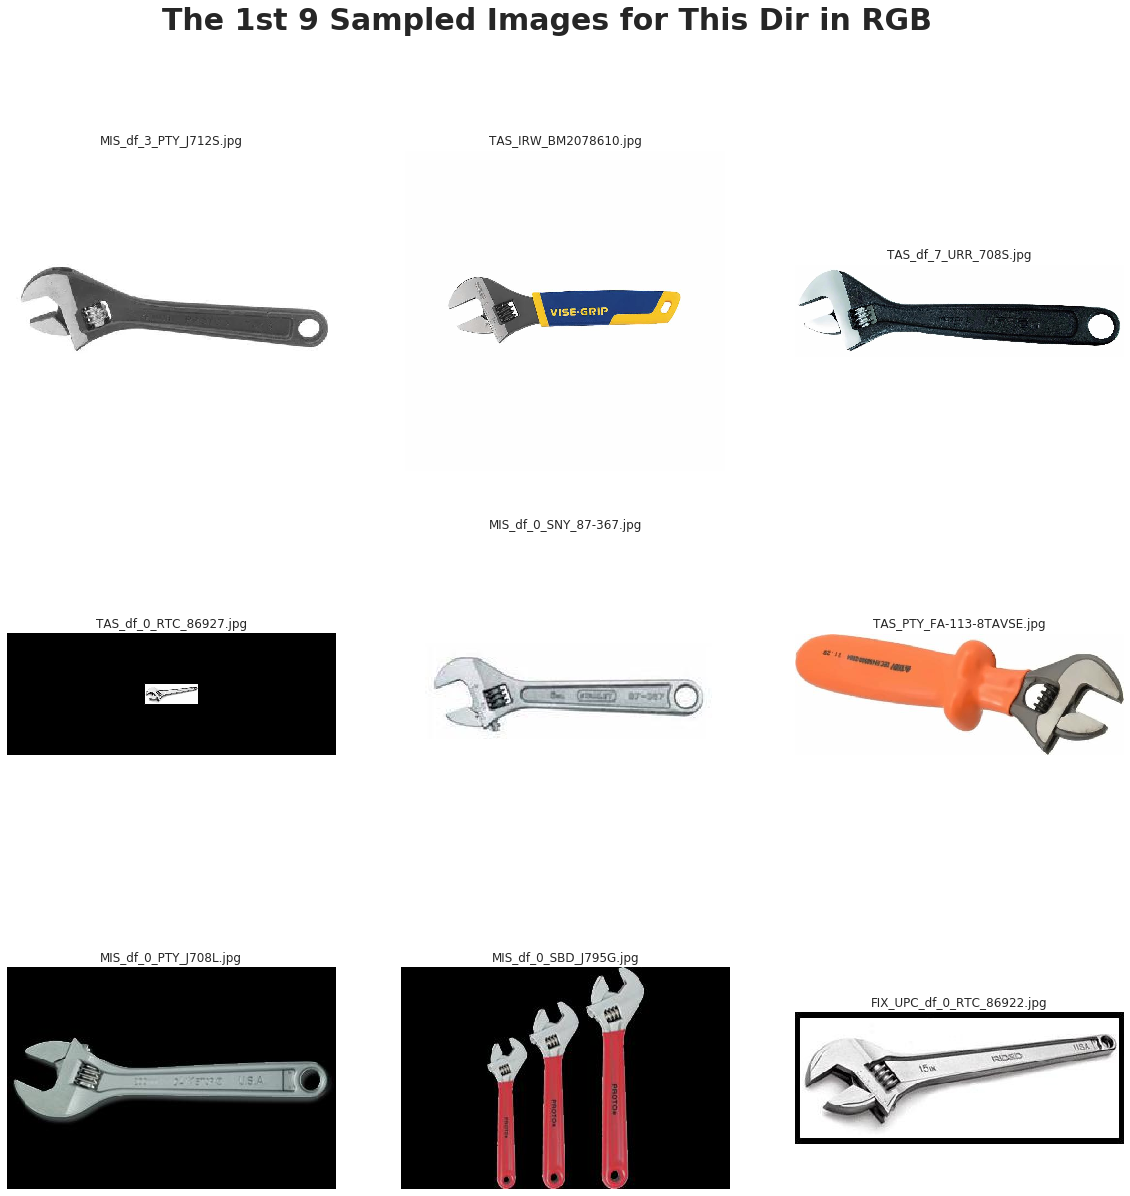

In [52]:
# Let's pick the 1st 9 sample images from this dir to view
plt.clf()
sample_cnt = 9
images_sample = imgs_sample
images_fids = fids_sample
plt.figure(figsize=(20,20))
plt.suptitle('The 1st 9 Sampled Images for This Dir in RGB', fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.title(images_fids[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(imgs_sample[i])

plt.show()

In [53]:
# ready the image as a processable, predictable tensor
fid_in = fids_sample[8]
img_tensor = process_img_in(fid_in)

In [54]:
# get top-5 predictions
pred_probs = my_model.predict(img_tensor)
top_5_idxs, top_5_labels = get_top_n_idxs_and_labels(pred_probs, idx_to_label_test_dict, 5)
pred_labels_top5 = top_5_labels[0]
top_5_fids, top_5_imgs = get_top_5_matches(pred_labels_top5)

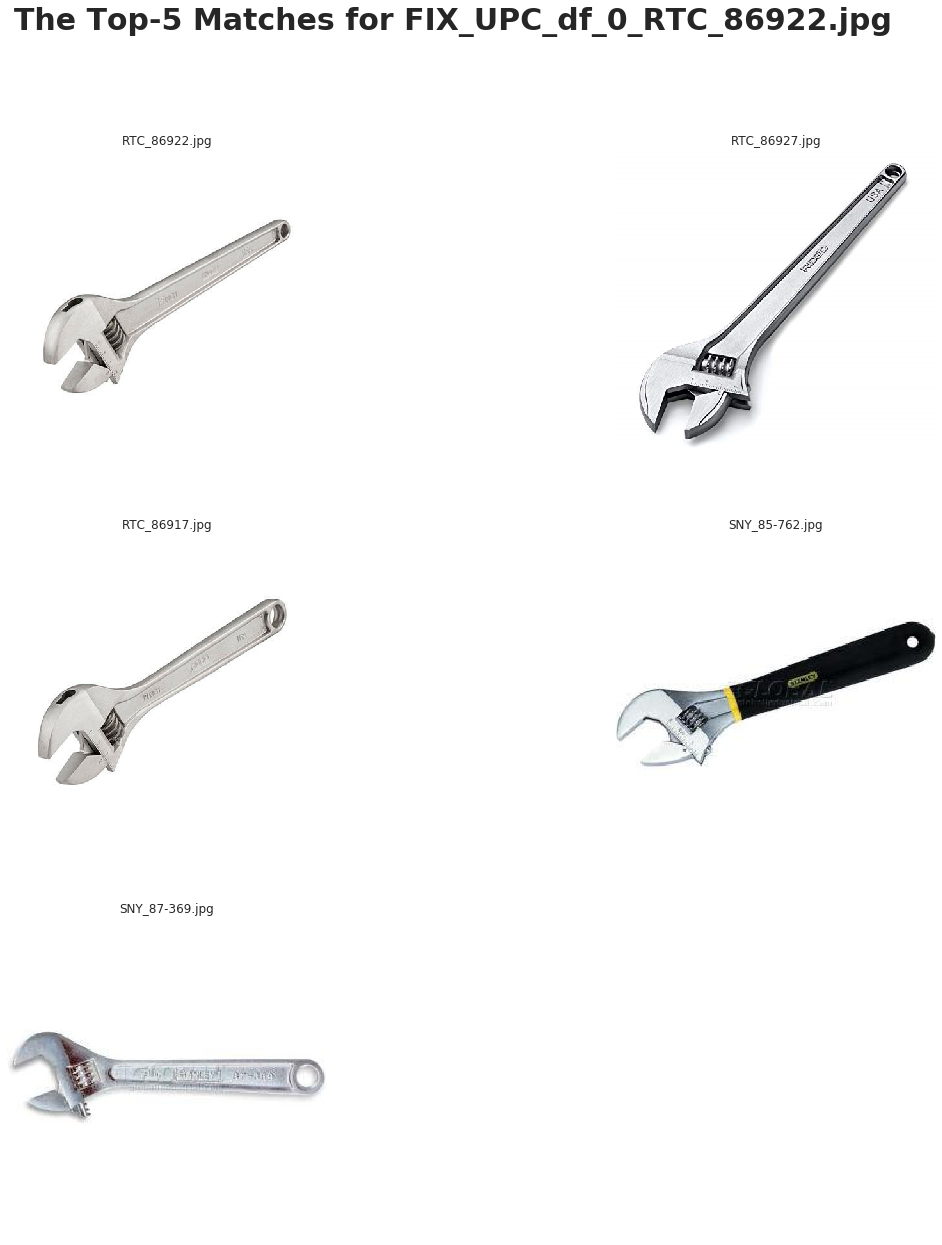

In [55]:
# Let's Look at those top-5 matches (hopefully)
plt.clf()
sample_cnt = 5
images_sample = top_5_imgs
images_fids = top_5_fids
# For each of the above pictures find the face bounding box
plt.figure(figsize=(20,20))
plt.suptitle('The Top-5 Matches for {}'.format(fid_in), fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(321 + (i))
    plt.title(images_fids[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample[i])

plt.show()

## ON TO DEPLOYMENT